In [1]:
# https://github.com/vectorgrp/coderskitchen-xai/blob/main/part2_Torch_guided_backprop.ipynb
# https://leslietj.github.io/2020/07/22/Deep-Learning-Guided-BackPropagation/
# 쉽게 말해서 원래 ReLU의 gradient는 input의 양수였던 pixel의 gradient만을 backpropagation하는데, guided backpropagation은 gradient가 음수인 부분 역시 backpropagation 못하게 한다.

In [2]:
import torch
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
from torchvision.models import vgg19, resnet18, resnet152
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import cv2

import warnings
warnings.filterwarnings("ignore")
txt = open('./942d3a0ac09ec9e5eb3a/imagenet1000_clsidx_to_labels.txt', "r").readlines()

lines_str = ''.join(txt)
import ast

# Convert the string to a dictionary
imagenet_class = ast.literal_eval(lines_str)


from PIL.Image import open

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])

path_list = ['n02504458_African_elephant.JPEG', 
             'n02106662_German_shepherd.JPEG', 
             'n01534433_junco.JPEG',
             'n04447861_toilet_seat.JPEG',
             'n04456115_torch.JPEG']
image_list = list()
for dir in path_list:
    image = open(f'imagenet-sample-images/{dir}')
    image_list.append(image)

image_batch = torch.stack([transform(image) for image in image_list])
image_batch.shape

torch.Size([5, 3, 224, 224])

In [4]:
class Guided_GradCAM_model(nn.Module):
    def __init__(self, model):
        super().__init__()
        if model == 'resnet152':
            self.model = resnet152(pretrained='ResNet152_Weights.IMAGENET1K_V1')

        elif model == 'resnet18':
            self.model = resnet18(pretrained='ResNet18_Weights.IMAGENET1K_V1')
        
        elif model == 'vgg19':
            self.model = vgg19(pretrained='VGG19_Weights.IMAGENET1K_V1')

        else:
            assert False, f'{model} is not available'

        self.model.eval()
        self.ignore_negative_relu()



        if model == 'resnet152':
            self.encoder = torch.nn.Sequential(*(list(self.model.children())[:-2]))
            self.pool = self.model.avgpool
            self.classifier = self.model.fc

        elif model == 'resnet18':
            self.encoder = torch.nn.Sequential(*(list(self.model.children())[:-2]))
            self.pool = self.model.avgpool
            self.classifier = self.model.fc
        
        elif model == 'vgg19':
            self.encoder = self.model.features
            self.pool = self.model.avgpool
            self.classifier = self.model.classifier

        self.gradients = None

        
    def relu_hook_function(self, module, grad_in, grad_out):
        if isinstance(module, torch.nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.),)
            
    def ignore_negative_relu(self):
        for i, module in enumerate(self.model.modules()):
            if isinstance(module, torch.nn.ReLU):
                module.register_backward_hook(self.relu_hook_function)

    def featuremap_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.encoder(x)
        x.register_hook(self.featuremap_hook)
        x = self.pool(x)
        x = x.flatten(start_dim = 1)
        x = self.classifier(x)
        return x
    
    def get_featuremap(self, x):
        return self.encoder(x)



In [5]:
model = Guided_GradCAM_model('resnet152').cuda()

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


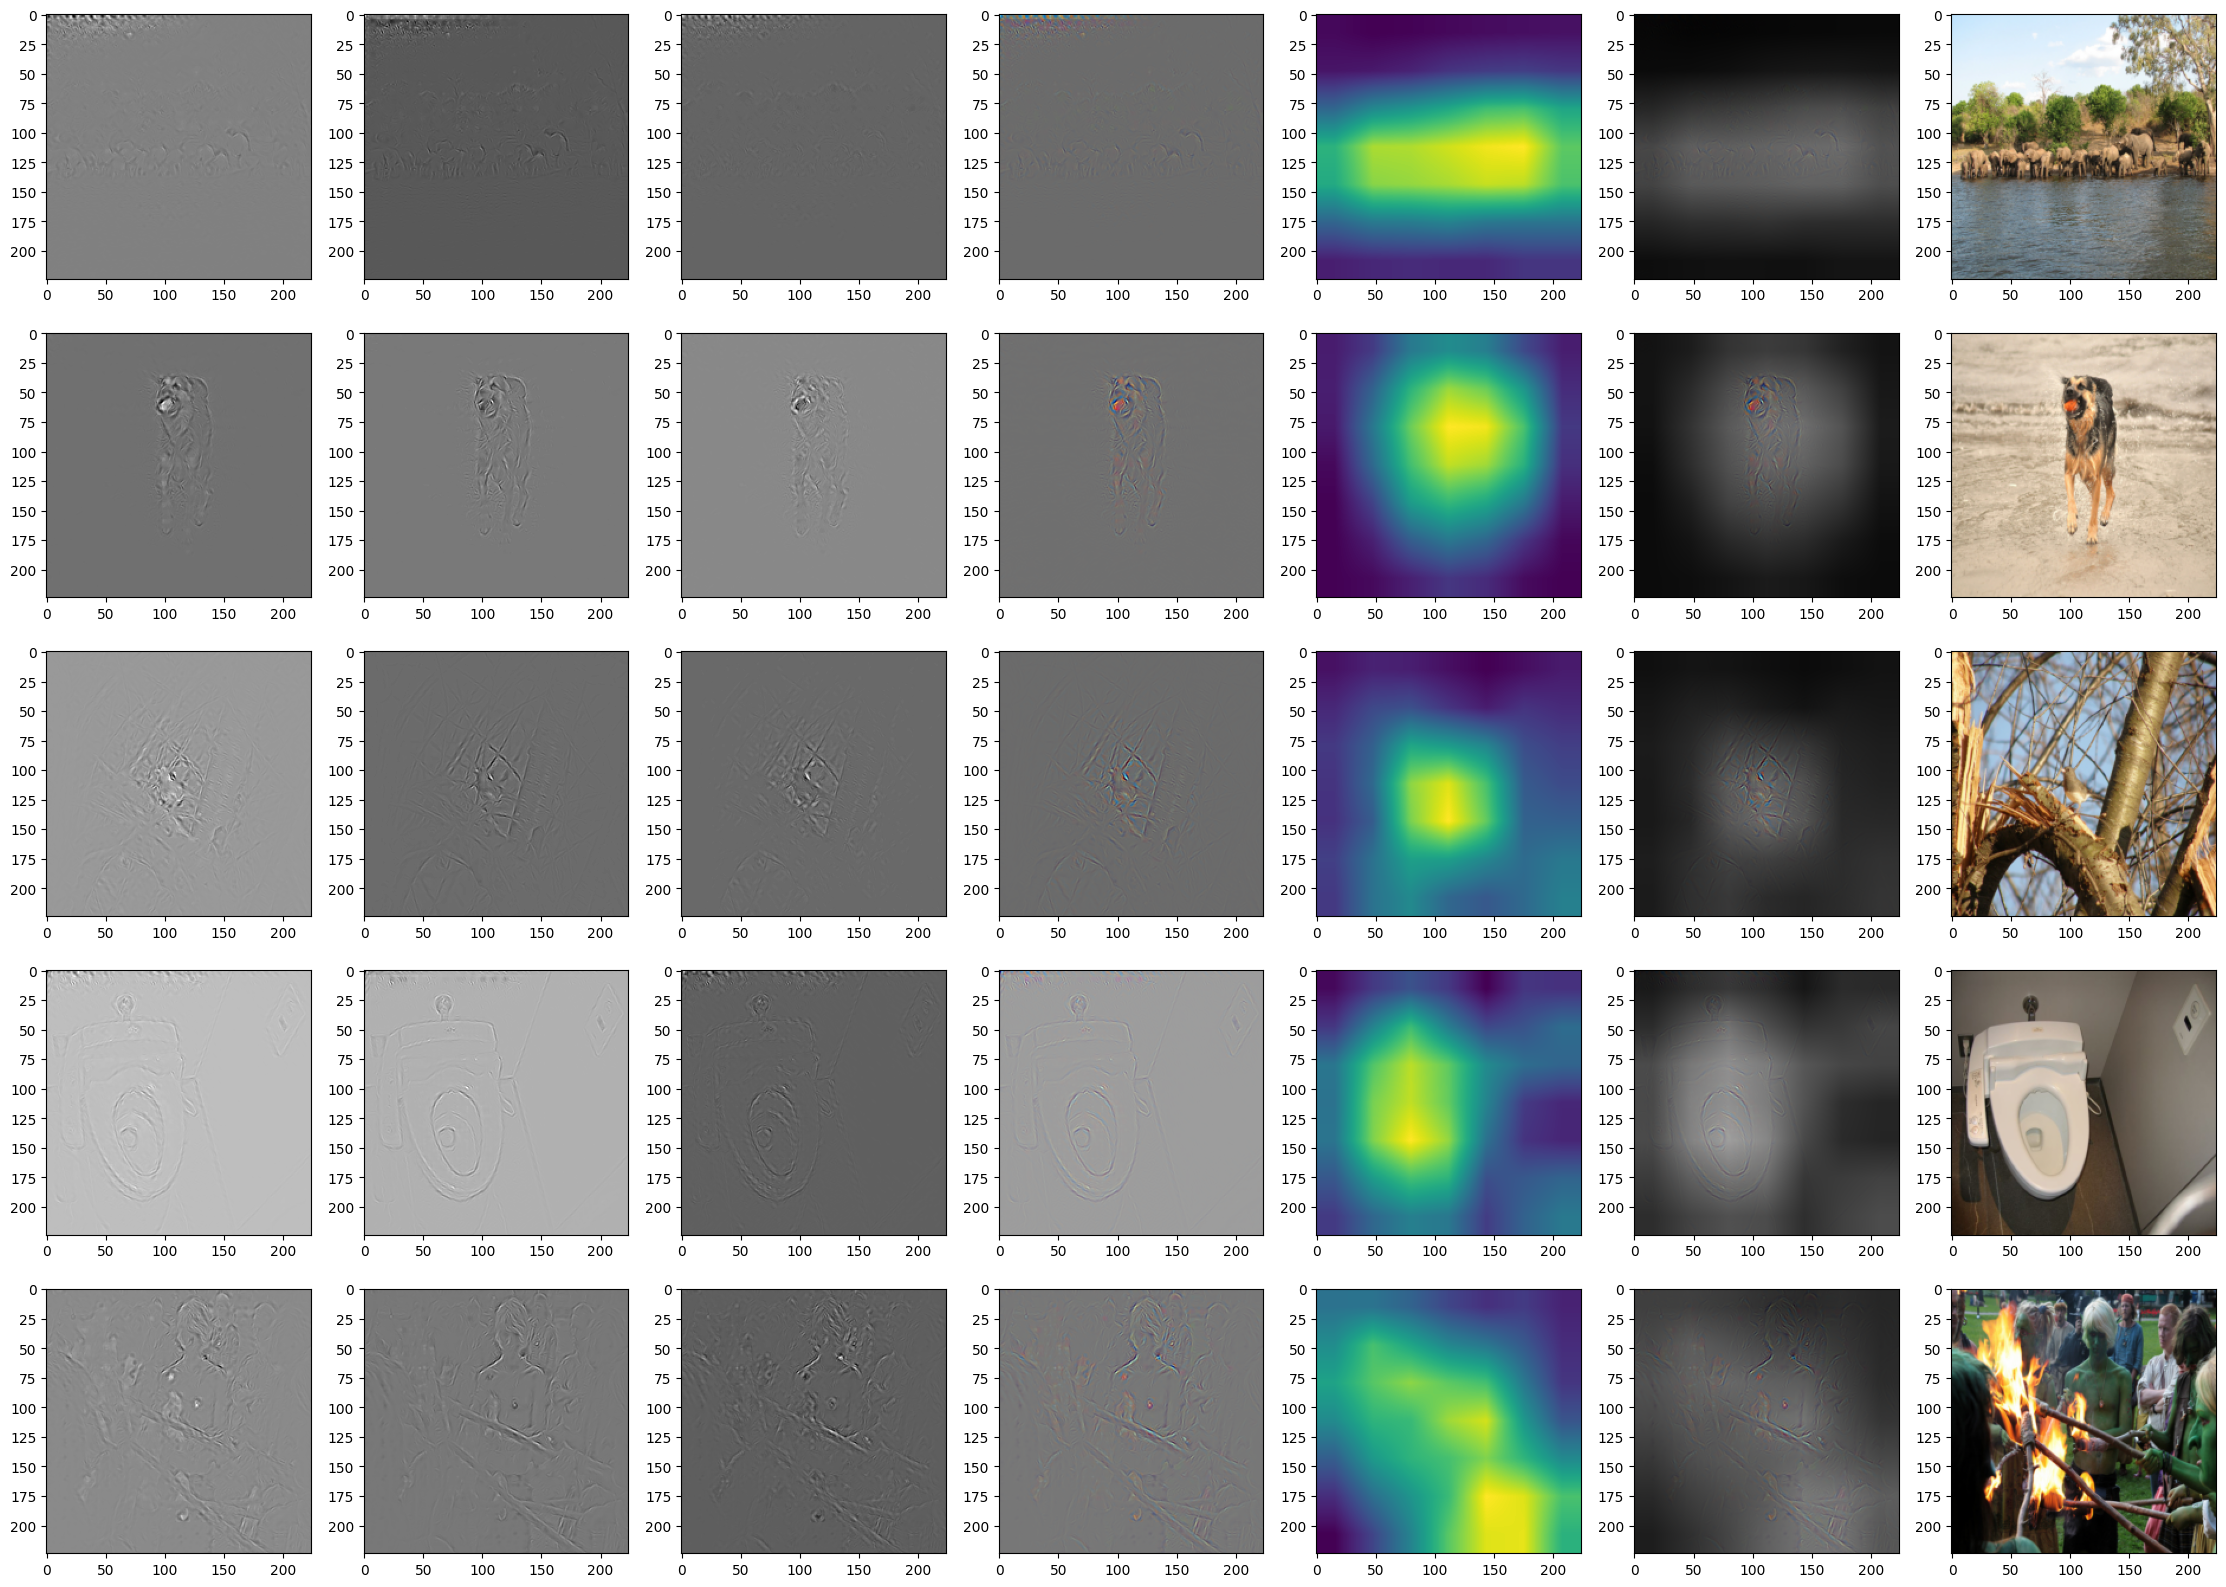

In [6]:
w = 7
h = 5

plt.figure(figsize = (4*w, 4*h))
for i, image in tqdm(enumerate(image_batch)):
    
    image = image.unsqueeze(dim = 0)
    image.requires_grad = True
    pred = model(image.cuda())
    # print(pred.max(dim = 1)[0])
    pred.max(dim = 1)[0].backward()
    gradients = image.grad
    
    plt.subplot(h,w,1+w*i)
    plt.imshow(gradients.detach().squeeze()[0].numpy(), cmap = 'gray')
    
    plt.subplot(h,w,2+w*i)
    plt.imshow(gradients.detach().squeeze()[1].numpy(), cmap = 'gray')
    
    plt.subplot(h,w,3+w*i)
    plt.imshow(gradients.detach().squeeze()[2].numpy(), cmap = 'gray')
    
    plt.subplot(h,w,4+w*i)
    plt.imshow(
        (gradients.detach().squeeze().numpy().transpose((1,2,0)) - gradients.detach().squeeze().numpy().transpose((1,2,0)).min()) / 
        (gradients.detach().squeeze().numpy().transpose((1,2,0)).max() - gradients.detach().squeeze().numpy().transpose((1,2,0)).min()) )
    
    plt.subplot(h,w,5+w*i)
    plt.imshow(gradients.detach().squeeze()[2].numpy(), cmap = 'gray')

    gradcam = model.gradients.detach().cpu()
    pooled_gradcam = torch.mean(gradcam, dim=[0, 2, 3])
    featuremap = model.get_featuremap(image.cuda()).detach().cpu()
    for j in range(512):
        featuremap[:, j, :, :] *= pooled_gradcam[i]
    heatmap = torch.mean(featuremap, dim=1).squeeze()
    heatmap = torch.nn.functional.relu(heatmap)
    heatmap /= torch.max(heatmap)
    # plt.imshow(heatmap)

    plt.subplot(h,w,5+w*i)
    heatmap = cv2.resize(np.array(heatmap), (224, 224))
    plt.imshow(heatmap)

    plt.subplot(h,w,6+w*i)
    plt.imshow(np.expand_dims(heatmap, axis = 2)*(gradients.detach().squeeze().numpy().transpose((1,2,0)) - gradients.detach().squeeze().numpy().transpose((1,2,0)).min()) / 
        (gradients.detach().squeeze().numpy().transpose((1,2,0)).max() - gradients.detach().squeeze().numpy().transpose((1,2,0)).min()))
    
    plt.subplot(h,w,7+w*i)
    plt.imshow(image.cpu().detach().numpy().squeeze().transpose((1,2,0))*[0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])

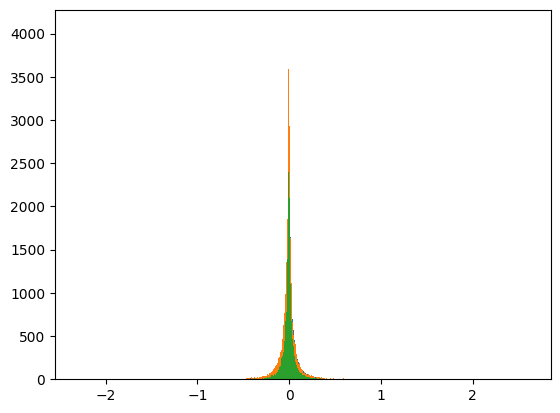

In [8]:
_ = plt.hist(gradients.detach().squeeze()[0].numpy().reshape(-1), bins = 1000)
_ = plt.hist(gradients.detach().squeeze()[1].numpy().reshape(-1), bins = 1000)
_ = plt.hist(gradients.detach().squeeze()[2].numpy().reshape(-1), bins = 1000)

In [10]:
torch.norm(gradients.detach().squeeze()[0]), torch.norm(gradients.detach().squeeze()[1]), torch.norm(gradients.detach().squeeze()[2])

(tensor(25.0232), tensor(27.7849), tensor(20.2994))